<a href="https://colab.research.google.com/github/rsaxby/dog-breed-classifier/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [72]:
import numpy as np
from glob import glob
from torchvision import datasets, models, transforms
import torchvision
import torch
import pandas as pd
import matplotlib.pyplot as plt
use_cuda = torch.cuda.is_available()
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

# load filenames for human and dog images
data_dir = '/content/drive/My Drive/Colab Notebooks/data/dog-breed-classifier_data/'

human_files = np.array(glob(data_dir+"humanImages/*/*"))
my_photos = np.array(glob(data_dir+"*.jpg"))
dog_files = np.array(glob(data_dir+"dogImages/*/*/*"))
dog_classes = np.array(glob(data_dir+"dogImages/train/*"))
num_dog_classes = len(dog_classes)
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('There are %d total personal images.' % len(my_photos))
print('There are %d total dog classes.' % num_dog_classes)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
There are 13233 total human images.
There are 8351 total dog images.
There are 2 total personal images.
There are 133 total dog classes.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


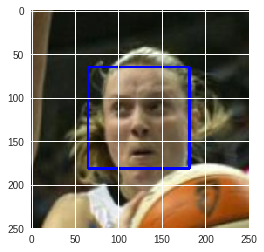

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(data_dir+'haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image - 
# detect multiscale finds the objects [faces in this case using face_cascade] 
# and returns a list of coordinates [rectangle] for each object found
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def assess_face_detector(hum_fp, dog_fp, detector):
    correct_humans = 0
    correct_dogs = 100
    for x in range(len(hum_fp)):
        humans = hum_fp[x]
        dogs = dog_fp[x]
        correct_humans += int(detector(humans))
        correct_dogs -= int(detector(dogs))
    print("Number of correct human faces: {}%".format(correct_humans)) #98%
    print("Number of correct dog faces: {}%".format(correct_dogs)) #83%
    
assess_face_detector(human_files_short,dog_files_short, face_detector)

Number of correct human faces: 100%
Number of correct dog faces: 81%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
    
# get class labels
# import json
# labels_ = json.load(open("imagenet_class_index.json"))
# print(f"Number of classes: {len(labels_)}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:19<00:00, 27877179.97it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path)
    
    # transforms for  img
    data_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])
    # apply transforms and move to gpu
    img = data_transforms(img).cuda()

    # add a dimension for the batch size
    img = img.unsqueeze(0)
    # feed img into pretrained model
    output = VGG16(img)
    
    # get the prediction
    _, pred_t = torch.max(output, 1)
    # convert from tensor to np array
    pred = torch.squeeze(pred_t).cpu().numpy()
    
    return pred # predicted class index


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred = VGG16_predict(img_path)
    return (pred >= 151 and pred <= 268) # true/false



### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def assess_dog_detector(hum_fp, dog_fp, detector):
    correct_humans = 100
    correct_dogs = 0
    for x in range(len(hum_fp)):
        humans = hum_fp[x]
        dogs = dog_fp[x]
        correct_humans -= int(detector(humans))
        correct_dogs += int(detector(dogs))
    print("Number of correct human faces: {}%".format(correct_humans)) # 100%
    print("Number of correct dog faces: {}%".format(correct_dogs)) # 100%
    
assess_dog_detector(human_files_short,dog_files_short, dog_detector)

Number of correct human faces: 100%
Number of correct dog faces: 95%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [41]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_path = data_dir+"dogImages/train/"
valid_path = data_dir+"dogImages/valid/"
test_path = data_dir+"dogImages/test/"
batch_size = 32

# transforms
train_transforms = transforms.Compose([
    transforms.RandomAffine(4, translate=(0.2,0.2), scale=None, shear=10, resample=False, fillcolor=0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]) 
])

# datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_path, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)
# get dog images for display in app later

dog_images = pd.DataFrame(data=None, index=[x.split('.')[0] for x in train_dataset.classes])
dog_images['classes'] = train_dataset.classes
dog_img_paths = [x.split('/',9)[9:][0] for x in dog_files]
one_img_per_class_imgs = []
one_img_per_class_fps = []
for c in dog_images['classes']:
  one_img_per_class_imgs.append(next(x[1] for x in dog_img_paths if str(c) in x))
  one_img_per_class_fps.append(next(x for x in dog_files if str(c) in x))
dog_images['images'] = one_img_per_class_imgs
dog_images['image_fps'] = one_img_per_class_fps
dog_images.index = np.arange(133)

# dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
loaders_scratch = {"train":train_dataloader, "valid":valid_dataloader, "test":test_dataloader}
dataset_sizes = {"train":len(train_dataloader), "valid":len(valid_dataloader), "test":len(test_dataloader)}
print(dataset_sizes)

{'train': 209, 'valid': 27, 'test': 27}


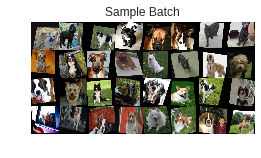

In [42]:
# show the image
def imshow(image, norm=True,ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 5))
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.set_title("{}".format(title))
    ax.grid(False)
    plt.axis('off')
    ax.imshow(image)
    
    return ax

# print a sample batch to visualize transforms
dataiter = iter(train_dataloader)
images, sample_labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), title="Sample Batch")

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: I chose the following transforms:

    transforms.RandomAffine(4, translate=(0.2,0.2), scale=None, shear=10, resample=False, fillcolor=0),
    RandomAffine to translate and shear the images to account for possible slight differences in the photo angles and positions of the dogs within the photos. 
    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ColorJitter to account for possible differences in lighting, contrast, and saturation within the photos. 
    
    transforms.RandomRotation(10),
    RandomRotation again to add variability to the photos so the network is able to generalize and adapt to various positions and angles of the dogs within the photos.
    
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    I resized to 224 and normalized using the following values because that's what a pretrained (ImageNet) network would require, and I decided to adhere to it for my model from scratch as well for consistency.
    
    transforms.ToTensor(),
    Finally, I convereted the array to a tensor to be fed into the network. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import math
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        ## Define layers of a CNN
        # conv layers
        self.conv3_32 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv32_32 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv32_64 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv64_64 = nn.Conv2d(64, 64, 3, padding=1)
        # pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # dropout
        self.dropout = nn.Dropout(0.5)
        # fc layers
        self.fc1 = nn.Linear(64*28*28, 512)
        self.fc2 = nn.Linear(512, self.num_classes)
        # initialize weights
        # for every module
        # m.weight.data shoud be taken from a normal distribution
        # m.bias.data should be 0
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # get the number of the inputs
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                y = math.sqrt(2./n)
                m.weight.data.normal_(0, y )
                m.bias.data.fill_(0)
                
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv3_32(x))
        x = self.pool(x)
        x = F.relu(self.conv32_32(x))
        x = self.pool(x)
        x = F.relu(self.conv32_64(x))
        x = self.pool(x)
        # flatten for fc layers
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net(len(train_dataset.classes))
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv3_32): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_64): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv64_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
)


In [0]:
# load model
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ My initial model architecture was just an implementation of VGG16, however I found that I was severely overfitting due to the depth of the network relative to the small dataset. 

The final architecture I settled on is a very pruned down version of VGG16, in which I significantly reduced the number of filters as well as the number of layers. This resulted in much better accuracy, and much less of a gap between the statistics (loss and accuracy) between my train/validation sets, and my test set. 

I originally had 3 fully connected layers and reducing it to 2 also helped reduce my overfitting. I included a dropout, which I originally set to 30%, but increasing it to 50% also helped increase generability. I used relu activation because it's standard to use in CNN's for its efficiency/fast compute time relative to other activation functions like tanh or sigmoid.

If I had more time, I would love to continue to refine this.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
import torch.optim as optim
from PIL import ImageFile

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # load truncated files
    ImageFile.LOAD_TRUNCATED_IMAGES = True   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print("[+] Training Model...")
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        running_correct = 0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # zero gradient
            optimizer.zero_grad()
            # forward pass
            outputs = model(data)
            # get loss
            loss = criterion(outputs, target)
            # backprop
            loss.backward()
            # update params
            optimizer.step()
            # update train loss
            train_loss += loss.item()*data.size(0)
            
            # statistics
            _,preds = torch.max(outputs, 1)
            running_correct += torch.mean((preds == target.data).type(torch.FloatTensor))
        epoch_loss = train_loss / len(loaders['train'])
        epoch_acc = running_correct.double() / len(loaders['train'])
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                "Train", epoch_loss, epoch_acc))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            valid_loss += loss.item()*data.size(0)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss/len(loaders['train']),
            valid_loss/len(loaders['valid'])
            ))
        ## TODO: save the model if validation loss has decreased

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


# train the model
from workspace_utils import active_session
with active_session():
    model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

[+] Training Model...
Epoch 1/29
----------
Train Loss: 155.0007 Acc: 0.0129
Epoch: 1 	Training Loss: 155.000659 	Validation Loss: 147.595103
Epoch 2/29
----------
Train Loss: 149.5705 Acc: 0.0291
Epoch: 2 	Training Loss: 149.570490 	Validation Loss: 141.280611
Epoch 3/29
----------
Train Loss: 145.1725 Acc: 0.0327
Epoch: 3 	Training Loss: 145.172479 	Validation Loss: 136.437301
Epoch 4/29
----------
Train Loss: 142.5582 Acc: 0.0467
Epoch: 4 	Training Loss: 142.558155 	Validation Loss: 137.600280
Epoch 5/29
----------
Train Loss: 139.7927 Acc: 0.0519
Epoch: 5 	Training Loss: 139.792672 	Validation Loss: 125.312989
Epoch 6/29
----------
Train Loss: 137.3927 Acc: 0.0591
Epoch: 6 	Training Loss: 137.392691 	Validation Loss: 127.810242
Epoch 7/29
----------
Train Loss: 134.9828 Acc: 0.0638
Epoch: 7 	Training Loss: 134.982751 	Validation Loss: 134.148609
Epoch 8/29
----------
Train Loss: 132.4991 Acc: 0.0738
Epoch: 8 	Training Loss: 132.499089 	Validation Loss: 125.888373
Epoch 9/29
-------

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):
    # load truncated files
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.173362


Test Accuracy: 13% (111/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [43]:
## TODO: Specify data loaders
# datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_path, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

# dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
loaders_transfer = {"train":train_dataloader, "valid":valid_dataloader, "test":test_dataloader}
dataset_sizes = {"train":len(train_dataloader), "valid":len(valid_dataloader), "test":len(test_dataloader)}
print(dataset_sizes)

{'train': 209, 'valid': 27, 'test': 27}


In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # load truncated files
    ImageFile.LOAD_TRUNCATED_IMAGES = True   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print("[+] Training Model...")
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        running_correct = 0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # zero gradient
            optimizer.zero_grad()
            # forward pass
            outputs = model(data)
            # get loss
            loss = criterion(outputs, target)
            # backprop
            loss.backward()
            # update params
            optimizer.step()
            # update train loss
            train_loss += loss.item()*data.size(0)
            
            # statistics
            _,preds = torch.max(outputs, 1)
            running_correct += torch.mean((preds == target.data).type(torch.FloatTensor))
        epoch_loss = train_loss / len(loaders['train'])
        epoch_acc = running_correct.double() / len(loaders['train'])
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                "Train", epoch_loss, epoch_acc))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            valid_loss += loss.item()*data.size(0)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss/len(loaders['train']),
            valid_loss/len(loaders['valid'])
            ))
        ## TODO: save the model if validation loss has decreased

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [45]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)
print(model_transfer.classifier[6])
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
# replace classifier    
in_features = model_transfer.classifier[6].in_features 
out_features = len(train_dataset.classes)
print(out_features)
model_transfer.classifier[6] = nn.Sequential(nn.Linear(in_features, out_features))
# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()

Linear(in_features=4096, out_features=1000, bias=True)
133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I used vgg16 as my base network because it's a relatively shallow network, and it has been trained on ImageNet images (including the dog breeds in question). I froze all layers, and used the network as is aside from creating my own classifier. For the classifier, I opted for a single fc layer to avoid overfitting. 
With this configuration, I was able to achieve 85% accuracy.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.Adam(model_transfer.classifier[6].parameters(), lr = 0.0003)

In [0]:
# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [48]:
# train the model
n_epochs=20
from PIL import ImageFile

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

[+] Training Model...
Epoch 1/19
----------
Train Loss: 56.6875 Acc: 0.5905
Epoch: 1 	Training Loss: 56.687493 	Validation Loss: 19.804039
Epoch 2/19
----------
Train Loss: 22.1584 Acc: 0.8031
Epoch: 2 	Training Loss: 22.158392 	Validation Loss: 19.448216
Epoch 3/19
----------
Train Loss: 17.7977 Acc: 0.8301
Epoch: 3 	Training Loss: 17.797716 	Validation Loss: 31.415606
Epoch 4/19
----------
Train Loss: 15.4991 Acc: 0.8497
Epoch: 4 	Training Loss: 15.499114 	Validation Loss: 20.321957
Epoch 5/19
----------
Train Loss: 14.4589 Acc: 0.8606
Epoch: 5 	Training Loss: 14.458889 	Validation Loss: 9.118564
Epoch 6/19
----------
Train Loss: 13.1075 Acc: 0.8702
Epoch: 6 	Training Loss: 13.107495 	Validation Loss: 11.377661
Epoch 7/19
----------
Train Loss: 12.0932 Acc: 0.8820
Epoch: 7 	Training Loss: 12.093246 	Validation Loss: 14.795883
Epoch 8/19
----------
Train Loss: 11.5874 Acc: 0.8776
Epoch: 8 	Training Loss: 11.587370 	Validation Loss: 26.490635
Epoch 9/19
----------
Train Loss: 10.5784 A

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [50]:
def test(loaders, model, criterion, use_cuda):
    # load truncated files
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.461502


Test Accuracy: 86% (719/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]
def load_image(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    trans1 = transforms.Resize((224, 224))
    trans2 = transforms.ToTensor()
    img = trans2(trans1(img))
    img.unsqueeze_(0)
    return img

def predict_breed_transfer(img, model):

    model.eval().cpu()
    outputs = model(img)
    outputs = torch.exp(outputs)
    probs, class_indices = outputs.topk(5)
    probs = list(probs.cpu().detach().numpy()[0])
    class_indices = list(class_indices.numpy()[0])
    # pred contains the predicted topk probabilities, and class indices
    pred = dict(zip(probs, class_indices))
    # return single label, prediction, image
    return  pred, img.cpu().squeeze(0)


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(model, img_path, labels, dog_images):
    ## handle cases for a human face, dog, and neither
    faces = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if faces or is_dog:
        img = load_image(img_path)
        pred, img = predict_breed_transfer(img, model)
        # get the top prediction
        max_prob = max(pred)
        # get the names of the predicted and actual class
        pred_class = int(pred[max_prob])

        if is_dog: 
            name= "dog! You must be a"
                # set the title of the plot
        else:
            name= "human. You most resemble a"
        
        title = "Hello {} {}".format(name,labels[pred_class].split('.')[1])
        dog_img = dog_images[dog_images.index == pred_class]['image_fps'].values[0]
        dog_img= load_image(dog_img)
        dog_img.squeeze_()
        images = [img, dog_img]
        imshow(torchvision.utils.make_grid(images), norm=False,title=title)
        
    else:
        print("No faces detected.")
    
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is 

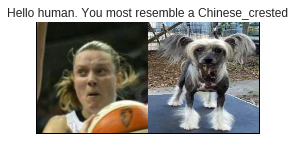

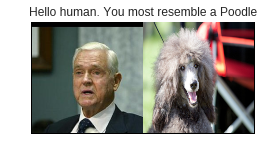

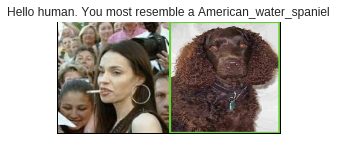

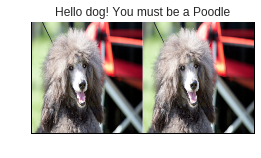

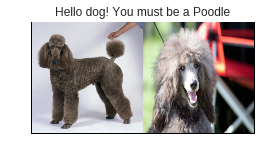

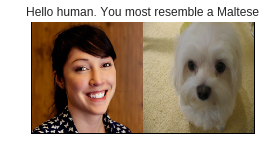

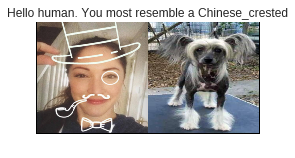

In [77]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import cv2
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(data_dir+'haarcascade_frontalface_alt.xml')
## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:2], my_photos[:])):
    run_app(model_transfer, file, train_dataset.classes, dog_images)
